In [1]:
import pandas as pd
import numpy as np
from scipy import spatial
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon
import fiona
import statistics
import contextily as cx
from os import listdir
from os.path import isfile, join
from haversine import haversine, Unit
import haversine as hs
import statsmodels.api as sm

In [2]:
mypath = '../../data/3 vehicles/'

In [3]:
def filterSubstr(lists, substr):
    return [x for x in lists if substr in x]


In [4]:


def main(searchStringDay,searchStringHour,cars):

    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    onlyfiles_xxx = filterSubstr(onlyfiles, searchStringDay)
    onlyfiles_xxx
    onlyfiles1 = filterSubstr(onlyfiles_xxx, searchStringHour)
    onlyfiles1

    allfiles = []
    for i in range(len(onlyfiles)):
        df = pd.read_csv(mypath + str(onlyfiles[i]), sep=';', decimal=',')
        df['Time[ms]'] = pd.to_datetime(df['Time[ms]'], unit='ms')
        df['driver'] = str(onlyfiles[i])[11:13]
        coord_ = [Point(x, y) for x, y in zip(df.Longitude, df.Latitude)]
        alldata_ = gpd.GeoDataFrame(df, geometry=coord_, crs ="EPSG:4326")
        allfiles.append(df)
    alldata = pd.concat(allfiles, axis=0).reset_index(drop=True)



    alldata['data'] = alldata['Time[ms]'].dt.date
    alldata["data"] = pd.to_datetime(alldata["data"])

    alldata_RW = alldata[alldata.driver == cars[0]]
    alldata_PS = alldata[alldata.driver == cars[1]]
    alldata_RG = alldata[alldata.driver == cars[2]]

    allfiles = []
    for i in range(len(onlyfiles)):
        df = pd.read_csv(mypath + str(onlyfiles[i]), sep=';', decimal=',')
        df['Time[ms]'] = pd.to_datetime(df['Time[ms]'], unit='ms')
        df['driver'] = str(onlyfiles[i])[11:13]
        coord_ = [Point(x, y) for x, y in zip(df.Longitude, df.Latitude)]
        alldata_ = gpd.GeoDataFrame(df, geometry=coord_, crs ="EPSG:4326")
        allfiles.append(df)

    alldata = pd.concat(allfiles, axis=0).reset_index(drop=True)
    alldata.driver.unique()
    alldata_SORTED = alldata.sort_values(by = 'Time[ms]').reset_index(drop=True)

    alldata_SORTED_cut = alldata_SORTED.dropna().reset_index(drop=True)
    alldata_SORTED_cut['Time'] = pd.to_datetime(alldata_SORTED_cut['Time[ms]'].dt.strftime('%H:%M:%S'))

    rw = alldata_SORTED_cut[alldata_SORTED_cut.driver == cars[0]].reset_index(drop=True).drop_duplicates()
    rg = alldata_SORTED_cut[alldata_SORTED_cut.driver == cars[1]].reset_index(drop=True).drop_duplicates()
    ps = alldata_SORTED_cut[alldata_SORTED_cut.driver == cars[2]].reset_index(drop=True).drop_duplicates()

    platoon_alldist = []
    platoon_all_CO2 = []

    platoon_all_lat_dist = []
    platoon_all_lon_dist = []

    platoon_all_lat_CO2 = []
    platoon_all_lon_CO2 = []

    #rw
    #rg
    #ps


    for i in range(len(rw)):
        try:
            platoon_lat_dist = []
            platoon_lon_dist = []
            platoon_lat_CO2 = []
            platoon_lon_CO2 = []
            platoon_dist = []
            CO2_max = []
            dist_mat = []

            rw_ = rw.iloc[i]

            df_array1 = (rw_.Latitude, rw_.Longitude)

            rg_ = rg[rg['Time'] > rw_['Time']].reset_index(drop=True)
            df_array2 = list(zip(rg_.Latitude, rg_.Longitude))[0:60]

            for j in range(len(df_array2)):
                dist_mat.append(hs.haversine(df_array1,df_array2[j],unit=Unit.METERS))

            rg_mindist = min(dist_mat)
            rg_mindist_index = dist_mat.index(rg_mindist)

            platoon_dist.append(rg_mindist)

            platoon_lat_dist.append(rg_.iloc[rg_mindist_index]["Latitude"])
            platoon_lon_dist.append(rg_.iloc[rg_mindist_index]["Longitude"])

            CO2 = []
            CO2.append(rg_.iloc[0]['CO2[kg]'])
            try:
                CO2.extend(list(rg_.iloc[1:21]['CO2[kg]']))
            except:
                pass

            rg_maxCO2 = max(CO2)
            rg_maxCO2_index = CO2.index(rg_maxCO2)
            CO2_max.append(rg_.reset_index(drop=True).iloc[rg_maxCO2_index]['CO2[kg]'])
            platoon_lat_CO2.append(rg_.reset_index(drop=True).iloc[rg_maxCO2_index]["Latitude"])
            platoon_lon_CO2.append(rg_.reset_index(drop=True).iloc[rg_maxCO2_index]["Longitude"])    


            ps_ = ps[ps['Time'] > rg_['Time'][rg_mindist_index]].reset_index(drop=True)
            df_array3 = list(zip(ps_.Latitude, ps_.Longitude))[0:60]        

            dist_mat = []

            for j in range(len(df_array3)):
                dist_mat.append(hs.haversine(df_array2[rg_mindist_index],df_array3[j],unit=Unit.METERS))

            ps_mindist = min(dist_mat)
            ps_mindist_index = dist_mat.index(ps_mindist)

            platoon_dist.append(ps_mindist)
            platoon_lat_dist.append(ps_.reset_index(drop=True).iloc[ps_mindist_index]["Latitude"])
            platoon_lon_dist.append(ps_.reset_index(drop=True).iloc[ps_mindist_index]["Longitude"])    

            CO2 = []

            CO2.append(ps_.iloc[0]['CO2[kg]'])
            try:
                CO2.extend(list(ps_.iloc[1:21]['CO2[kg]']))
            except:
                pass
            ps_maxCO2 = max(CO2)
            ps_maxCO2_index = CO2.index(ps_maxCO2)
            CO2_max.append(ps_.reset_index(drop=True).iloc[ps_maxCO2_index]['CO2[kg]'])
            platoon_lat_CO2.append(ps_.reset_index(drop=True).iloc[ps_maxCO2_index]["Latitude"])
            platoon_lon_CO2.append(ps_.reset_index(drop=True).iloc[ps_maxCO2_index]["Longitude"])  


            platoon_all_lat_dist.append(platoon_lat_dist)
            platoon_all_lon_dist.append(platoon_lon_dist)
            platoon_all_lat_CO2.append(platoon_lat_CO2)
            platoon_all_lon_CO2.append(platoon_lon_CO2)
            platoon_alldist.append(platoon_dist)
            platoon_all_CO2.append(CO2_max)
        except:
            pass


    pd.DataFrame(platoon_alldist, columns = ['RW_RG', 'RG_PS']).plot(figsize=(30,10))




    dist_v = pd.DataFrame(platoon_alldist, columns = ['RW_RG', 'RG_PS'])
    pd.DataFrame(platoon_alldist, columns = ['RW_RG', 'RG_PS']).to_csv('distance_platoon.csv', index=False)

    dist_coord = pd.concat([pd.DataFrame(platoon_all_lat_dist, columns=['v1_lat', 'v2_lat'])['v1_lat'], pd.DataFrame(platoon_all_lon_dist, columns=['v1_lon', 'v2_lon'])['v1_lon'],pd.DataFrame(platoon_all_lat_dist, columns=['v1_lat', 'v2_lat'])['v2_lat'], pd.DataFrame(platoon_all_lon_dist, columns=['v1_lon', 'v2_lon'])['v2_lon']], axis=1)

    pd.concat([pd.DataFrame(platoon_all_lat_dist, columns=['v1_lat', 'v2_lat'])['v1_lat'], pd.DataFrame(platoon_all_lon_dist, columns=['v1_lon', 'v2_lon'])['v1_lon'],pd.DataFrame(platoon_all_lat_dist, columns=['v1_lat', 'v2_lat'])['v2_lat'], pd.DataFrame(platoon_all_lon_dist, columns=['v1_lon', 'v2_lon'])['v2_lon']], axis=1).to_csv('platoon_distances_coord.csv', index=False)

    infr = pd.read_csv('../../data/infrast_data_update_.csv', sep=';')
    infr.what.unique()

    allveic = []
    for k in range(0, len(dist_coord.columns)-1, 2):
        print(k,len(dist_coord.columns))
        veic = []
        for i in range(len(dist_coord)):
            infra = []
            for j in range(len(infr)):
                inf = (infr.iloc[j].lat,infr.iloc[j].lon)
                distcoor = (dist_coord.iloc[i][str(dist_coord.columns[k])], dist_coord.iloc[i][str(dist_coord.columns[k+1])])
                infra.append(hs.haversine(inf,distcoor,unit=Unit.METERS))
            veic.append(infra)
        allveic.append(veic)


    v1 = pd.DataFrame(allveic[0])
    v2 = pd.DataFrame(allveic[1])

    allfeat = []
    for i in range(len(v1)): 
        allfeat.append(list(v1[v1<500].iloc[i].dropna()))
    new_v1 = pd.DataFrame(allfeat).iloc[:,0:7].fillna(0)

    allfeat = []
    for i in range(len(v2)): 
        allfeat.append(list(v2[v2<500].iloc[i].dropna()))
    new_v2 = pd.DataFrame(allfeat).iloc[:,0:7].fillna(0)

    v1.columns = infr.what
    v2.columns = infr.what

    vlist = []
    vlist.append(v1)
    vlist.append(v2)


    all_X = []
    all_y = []

    for k in range(len(vlist)):
        feats = []
        v = vlist[k]
        infrast = v.idxmin(axis=1)
        for i in range(len(v)):
            if (v.iloc[i][str(infrast[i])] < 80).any():
                feats.append([infrast[i]])
            else:
                feats.append([])
        new_v = pd.get_dummies(pd.DataFrame(feats), prefix='Feat')

        X = new_v.copy()
        y = dist_v[str(dist_v.columns[k])]
        X['old_dist'] = dist_v[str(dist_v.columns[k])].shift(10).fillna(0)
        all_X.append(X)
        all_y.append(y)

    all_X_ = pd.concat(all_X).reset_index(drop=True).fillna(0)
    all_y_ = pd.concat(all_y).reset_index(drop=True).fillna(0)
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X)
    model.summary()

    results_summary = model.summary()
    df = pd.DataFrame.from_records(results_summary.tables[1].data)
    header = df.iloc[0]
    df = df[1:] # take the data less the header row
    df.columns = header
    df.to_csv(f'../../results/Dist/platoon_3_{searchStringDay}{searchStringHour}.csv')

    platoon_all_CO2_ = pd.DataFrame(platoon_all_CO2, columns = ['RG_LA', 'LA_PS'])
    pd.DataFrame(platoon_all_CO2, columns = ['RW_LA', 'LA_PS']).to_csv('CO2_platoon.csv', index=False)

    all_X = []
    all_y = []

    for k in range(len(vlist)):
        feats = []
        v = vlist[k]
        infrast = v.idxmin(axis=1)
        for i in range(len(v)):
            if (v.iloc[i][str(infrast[i])] <80).any():
                feats.append([infrast[i]])
            else:
                feats.append([])
        new_v = pd.get_dummies(pd.DataFrame(feats), prefix='Feat')

        X = new_v.copy()
        y = platoon_all_CO2_[str(platoon_all_CO2_.columns[k])]
        X['old_dist'] = dist_v[str(dist_v.columns[k])].shift(10).fillna(0)
        all_X.append(X)
        all_y.append(y)

    all_X_ = pd.concat(all_X).reset_index(drop=True).fillna(0)
    all_y_ = pd.concat(all_y).reset_index(drop=True).fillna(0)
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X)
    model.summary()
    results_summary = model.summary()
    df = pd.DataFrame.from_records(results_summary.tables[1].data)
    header = df.iloc[0]
    df = df[1:] # take the data less the header row
    df.columns = header
    df.to_csv(f'../../results/CO2/platoon_3_{searchStringDay}{searchStringHour}.csv')

0 4
2 4
0 4
2 4
0 4
2 4
0 4
2 4
0 4
2 4
0 4
2 4
0 4
2 4
0 4
2 4


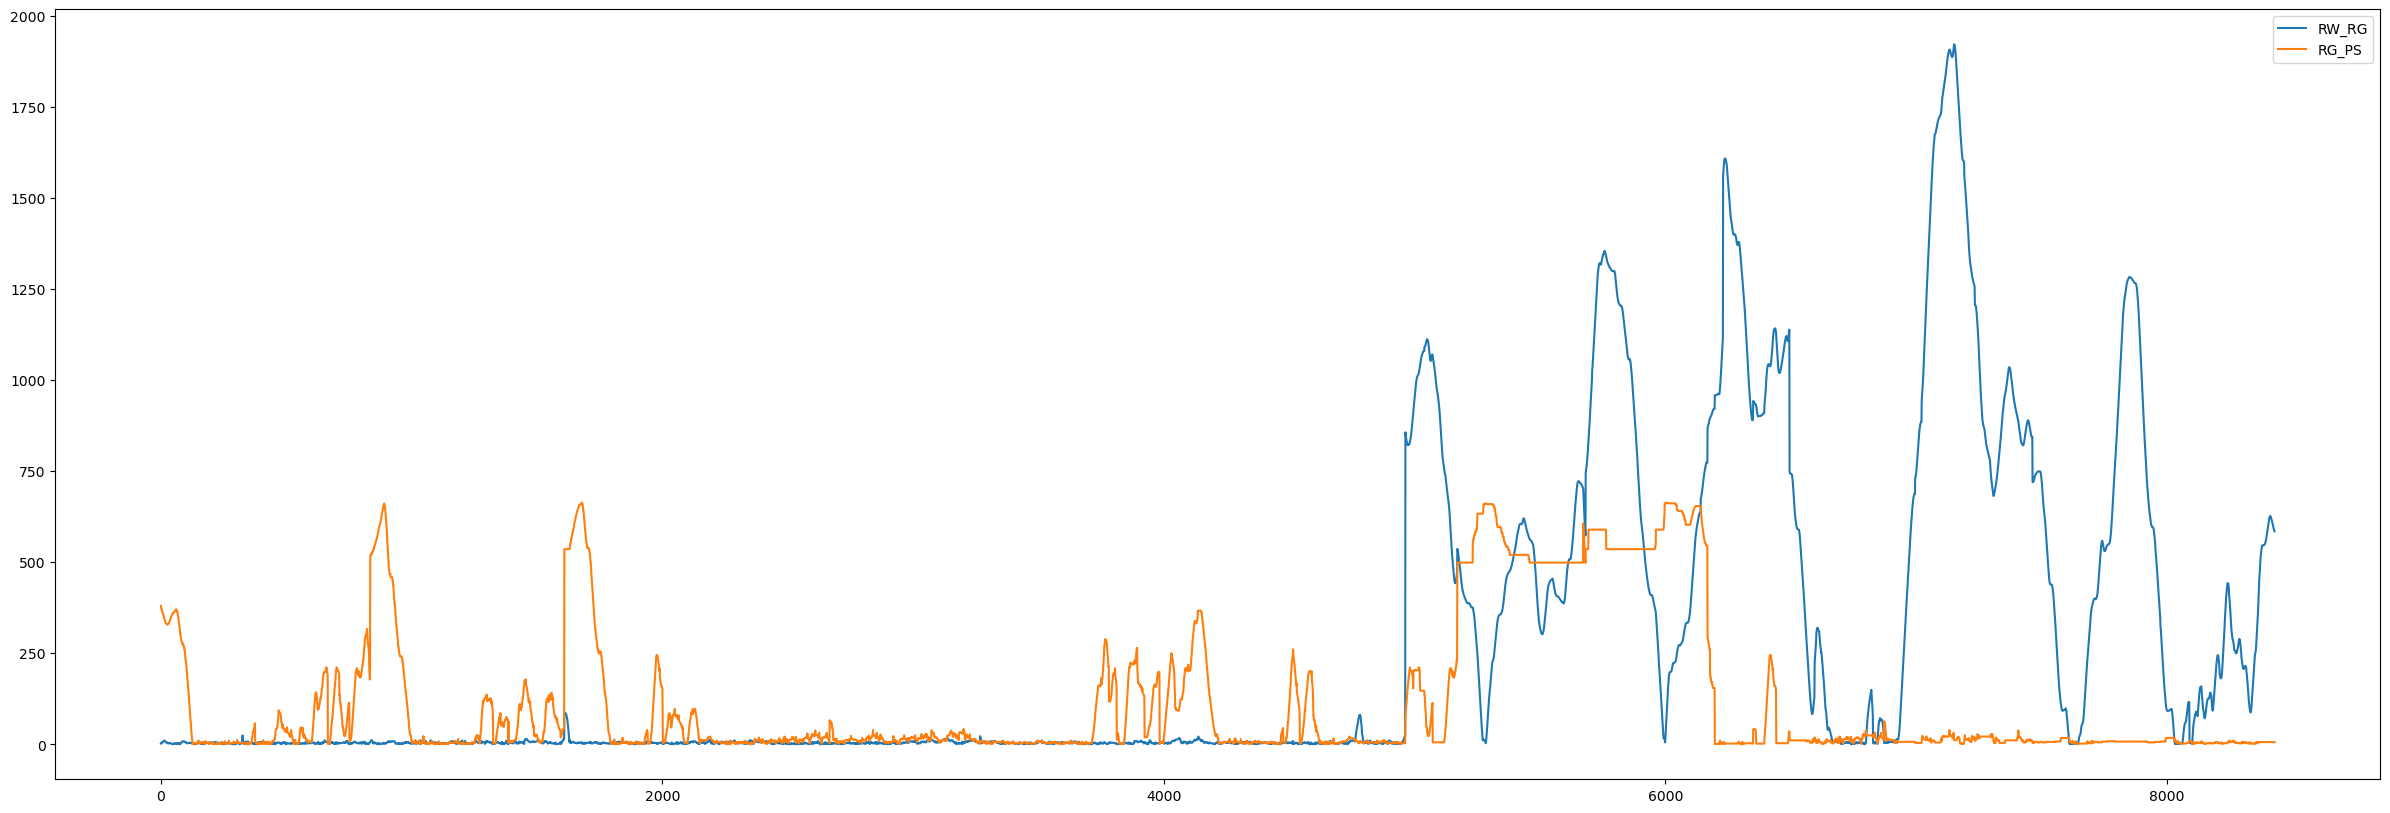

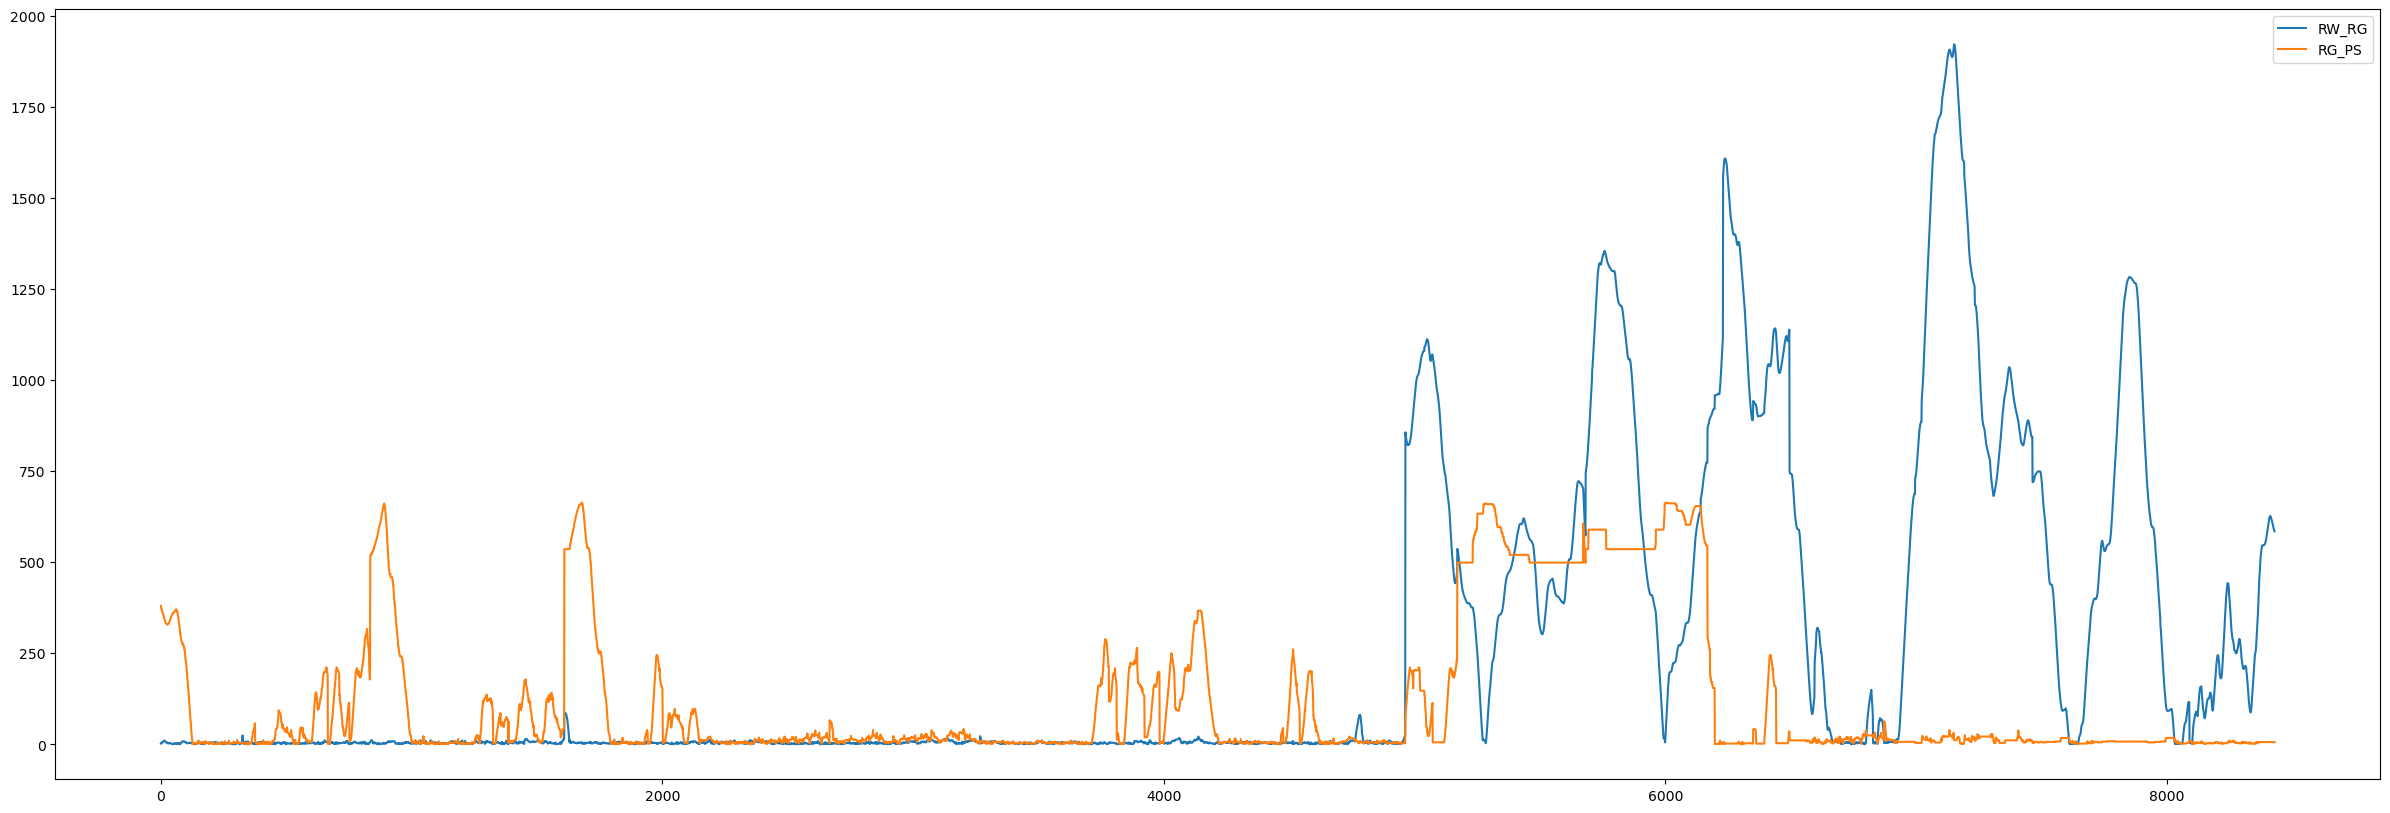

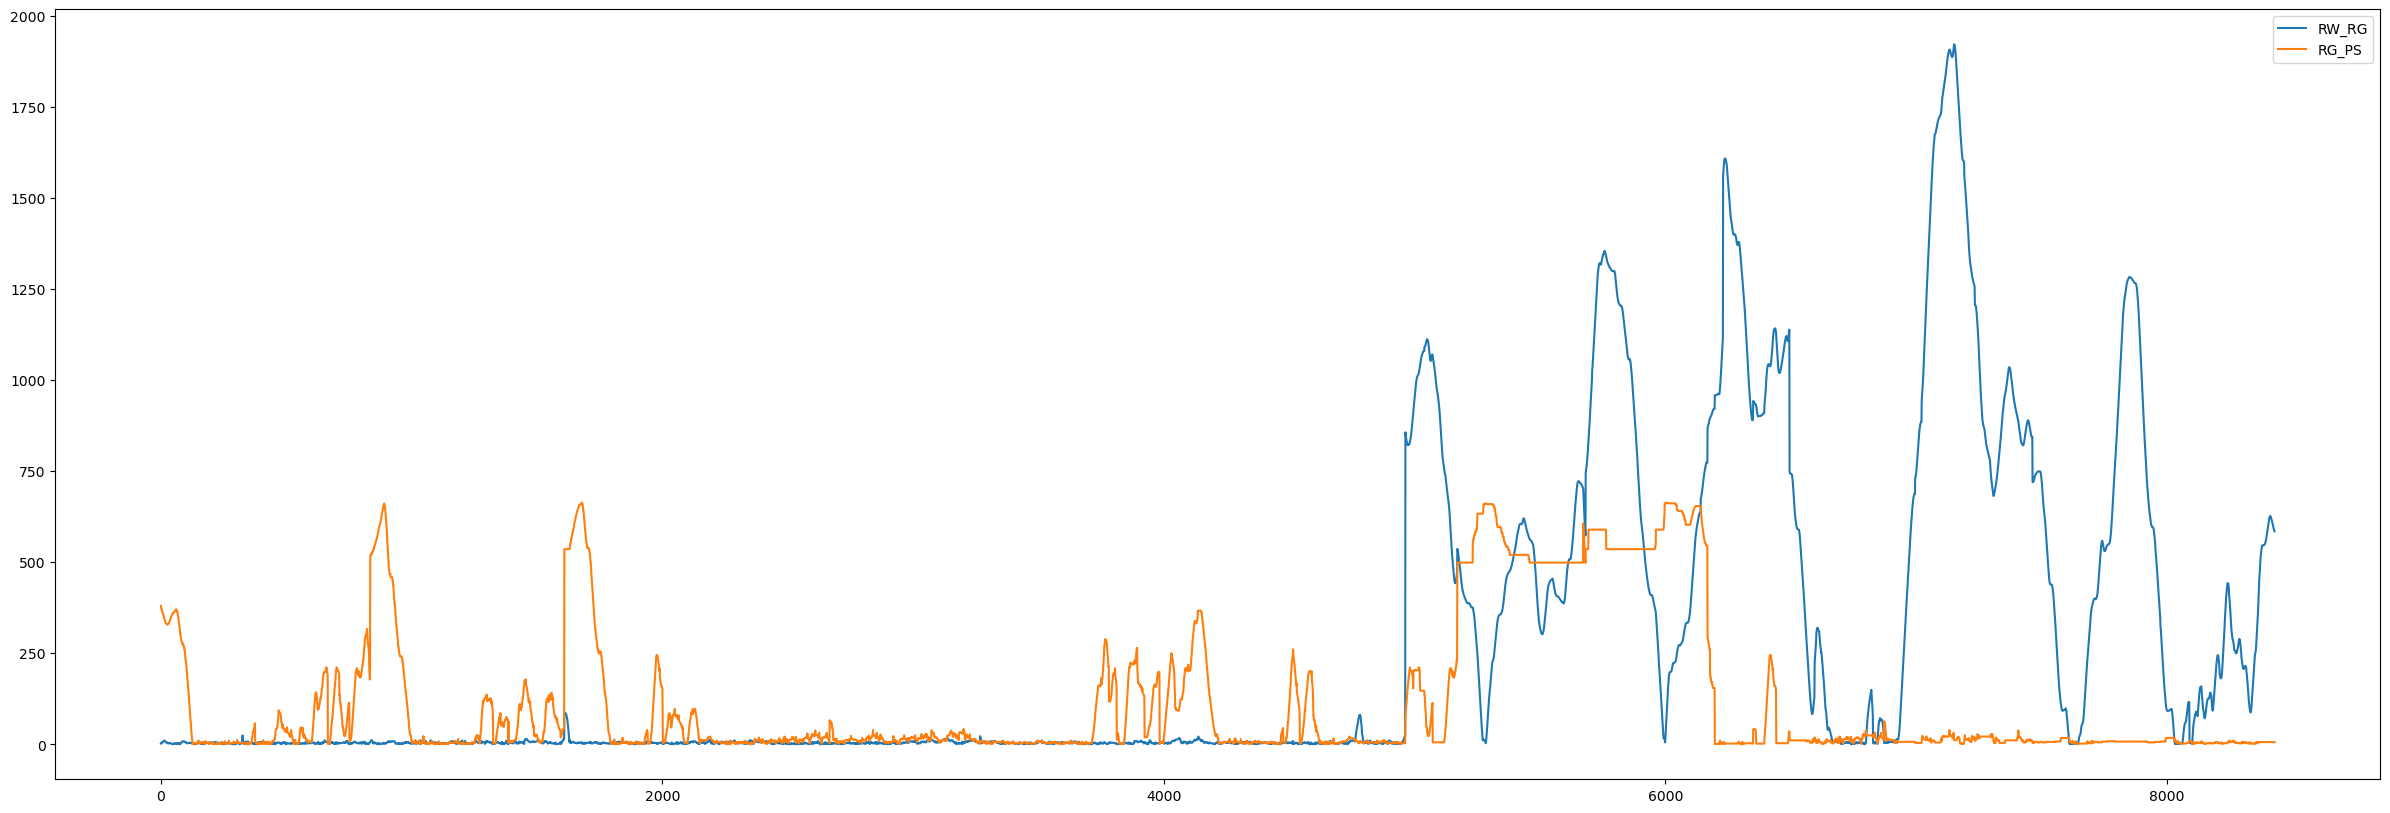

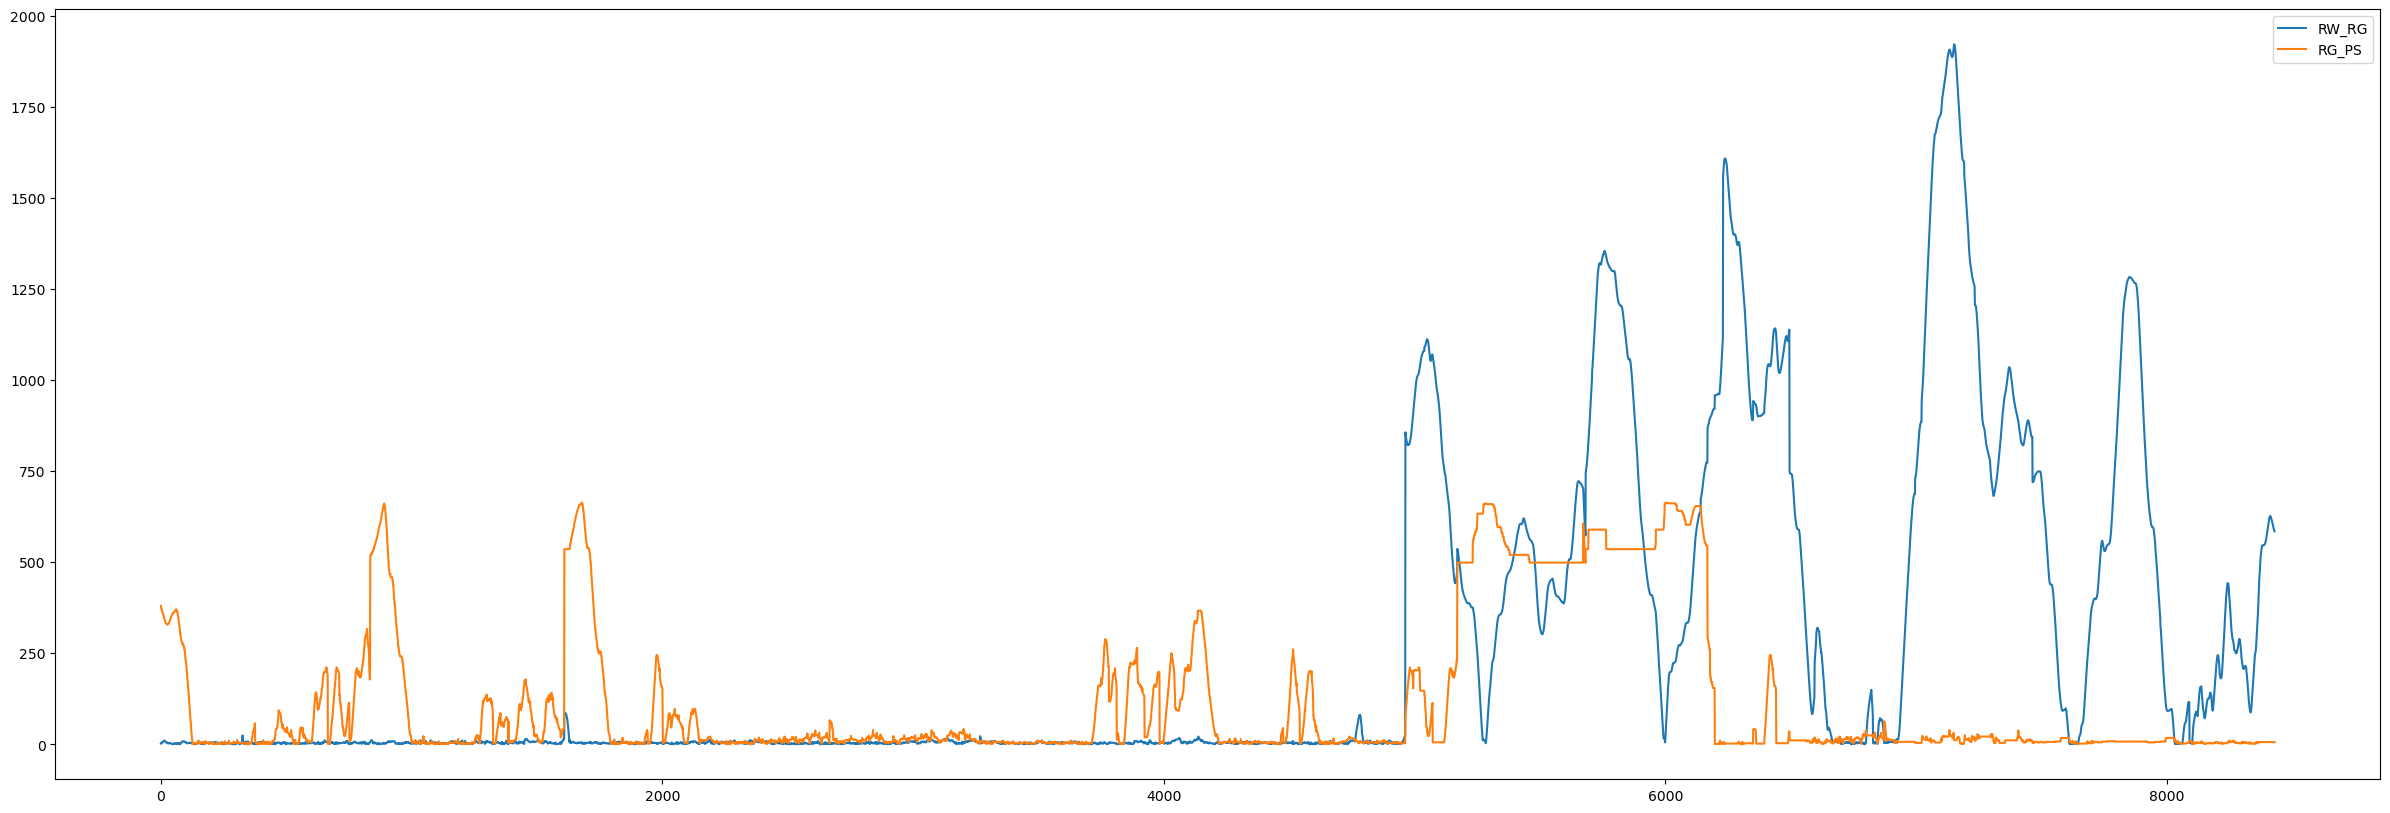

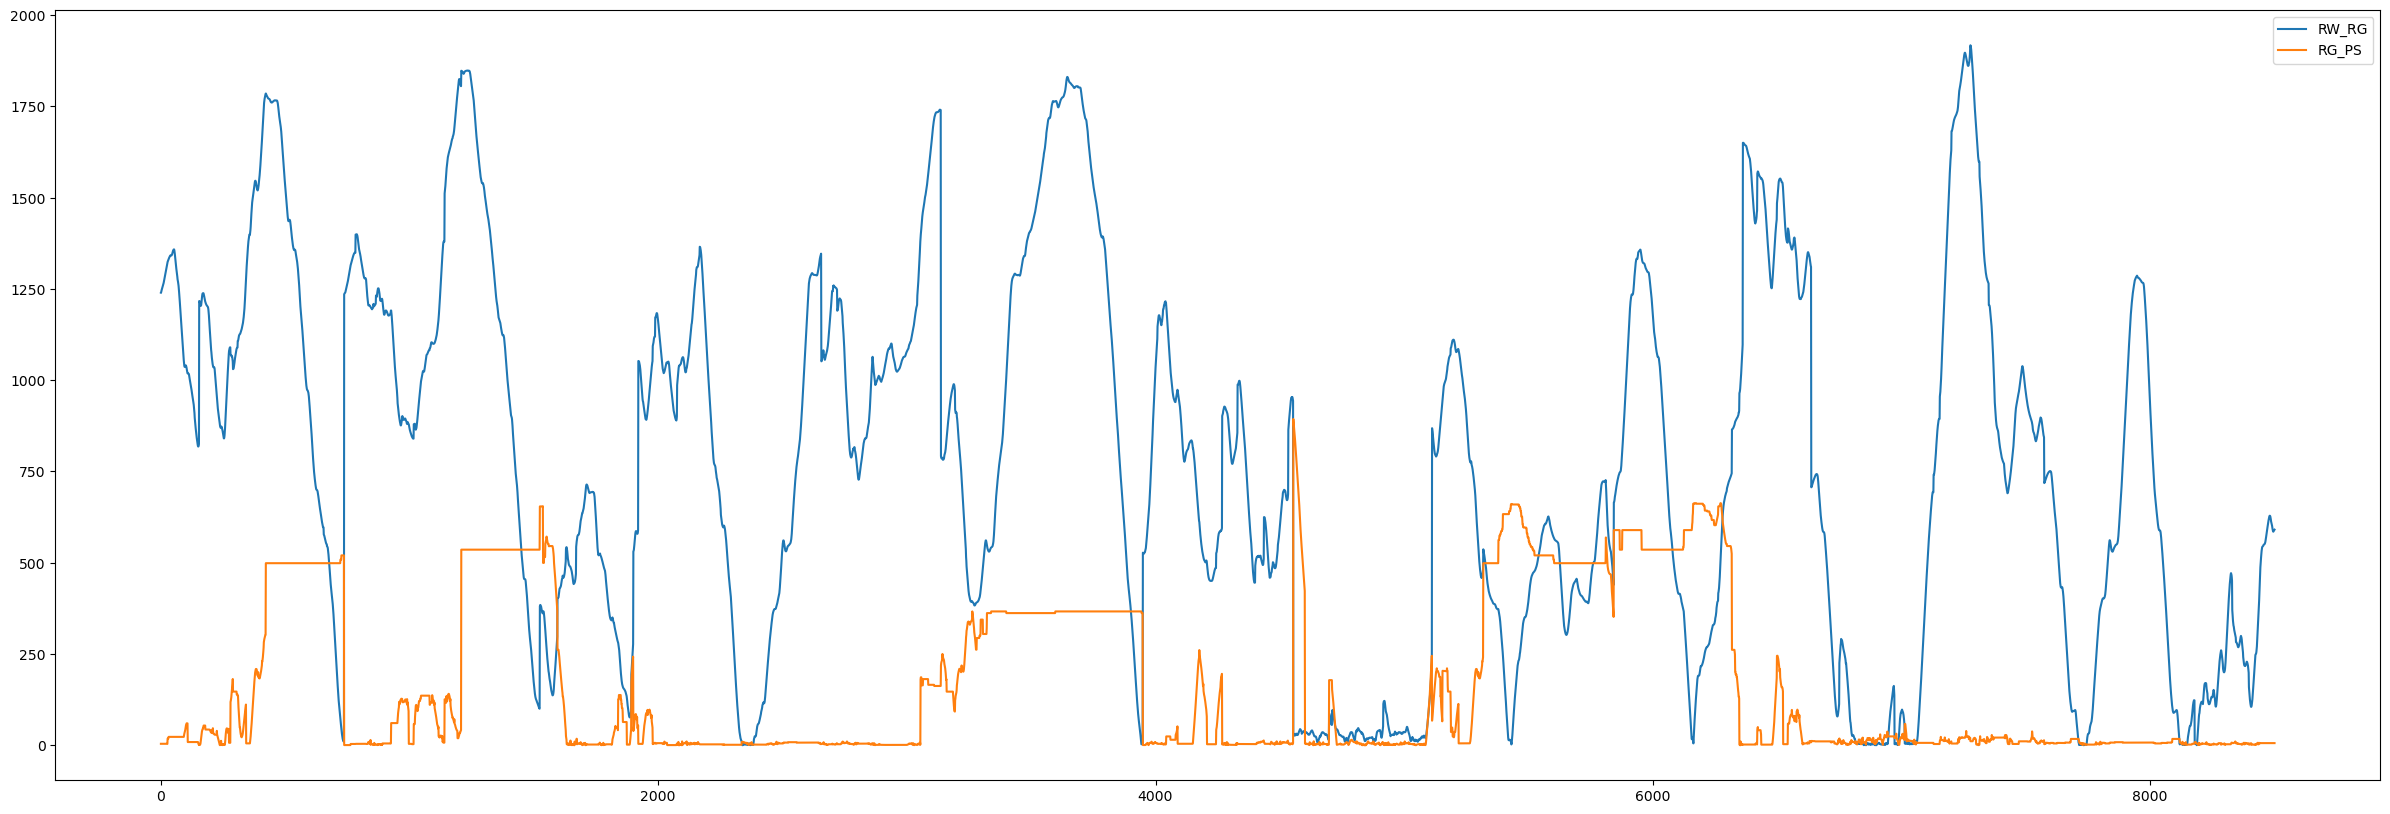

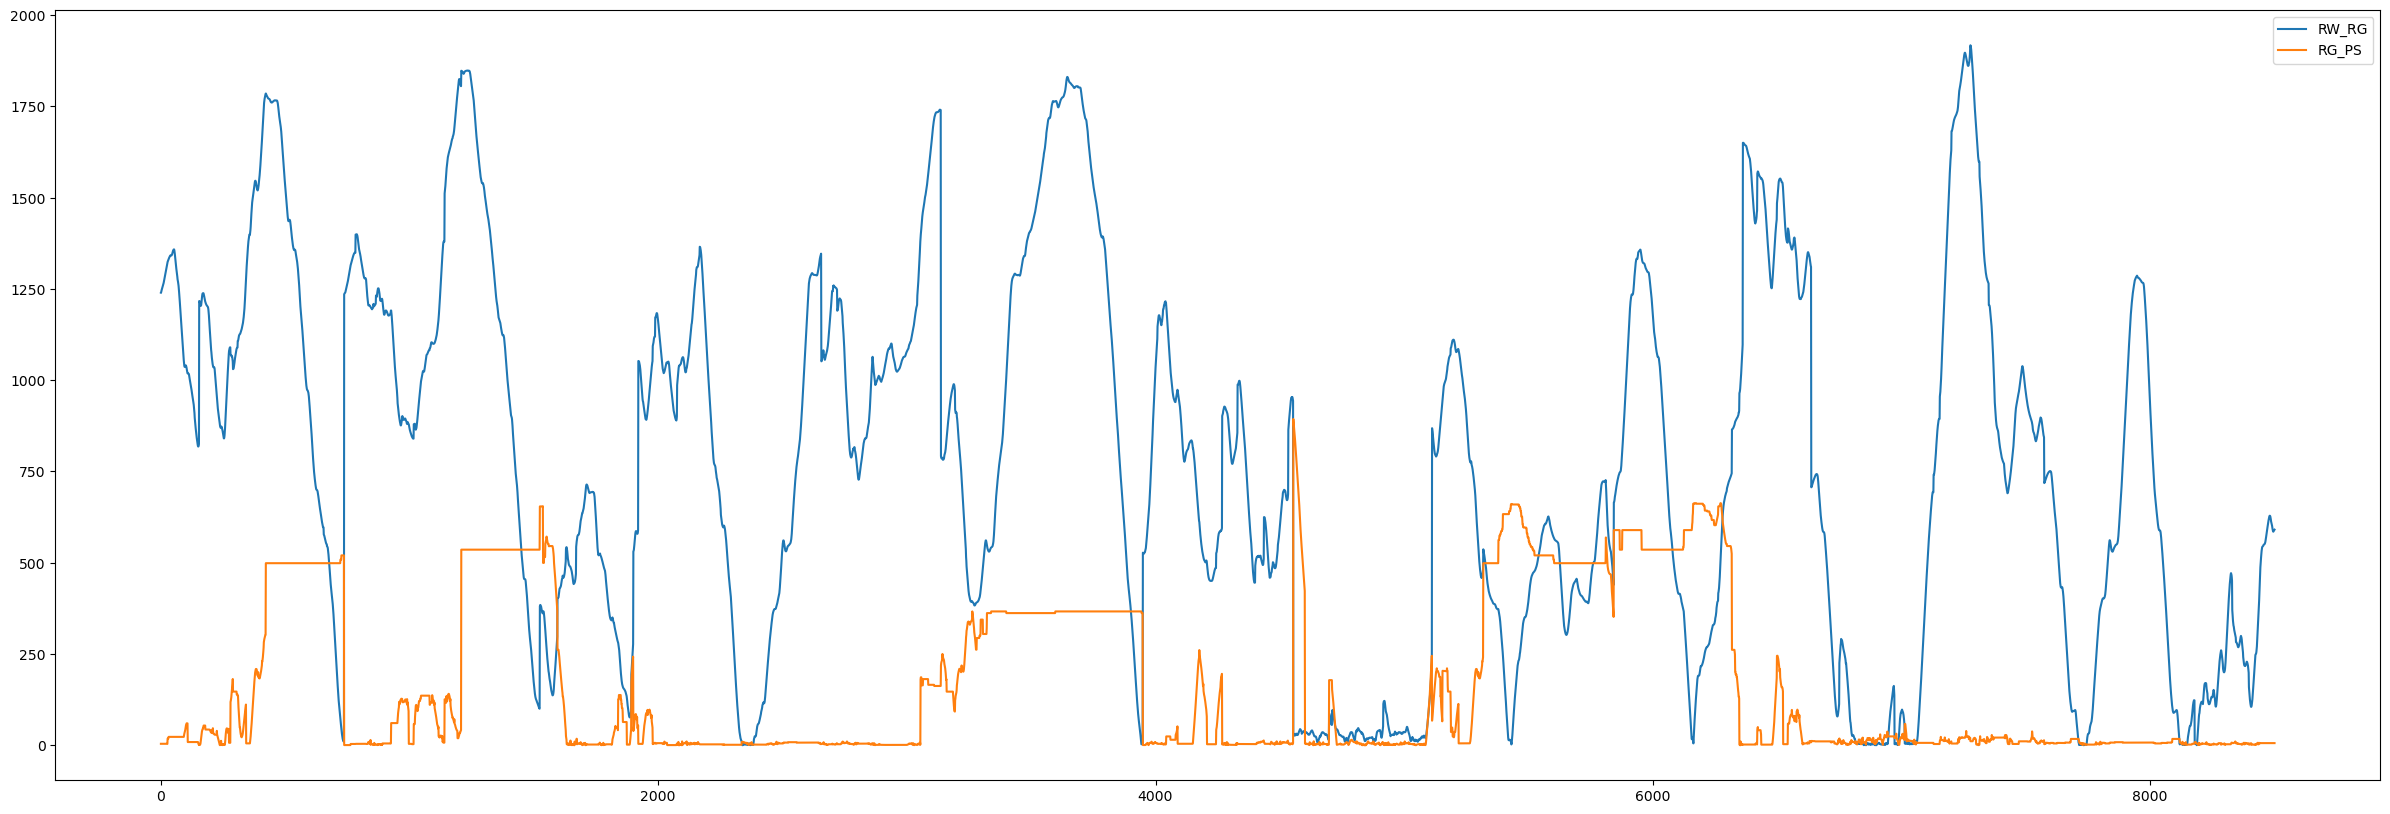

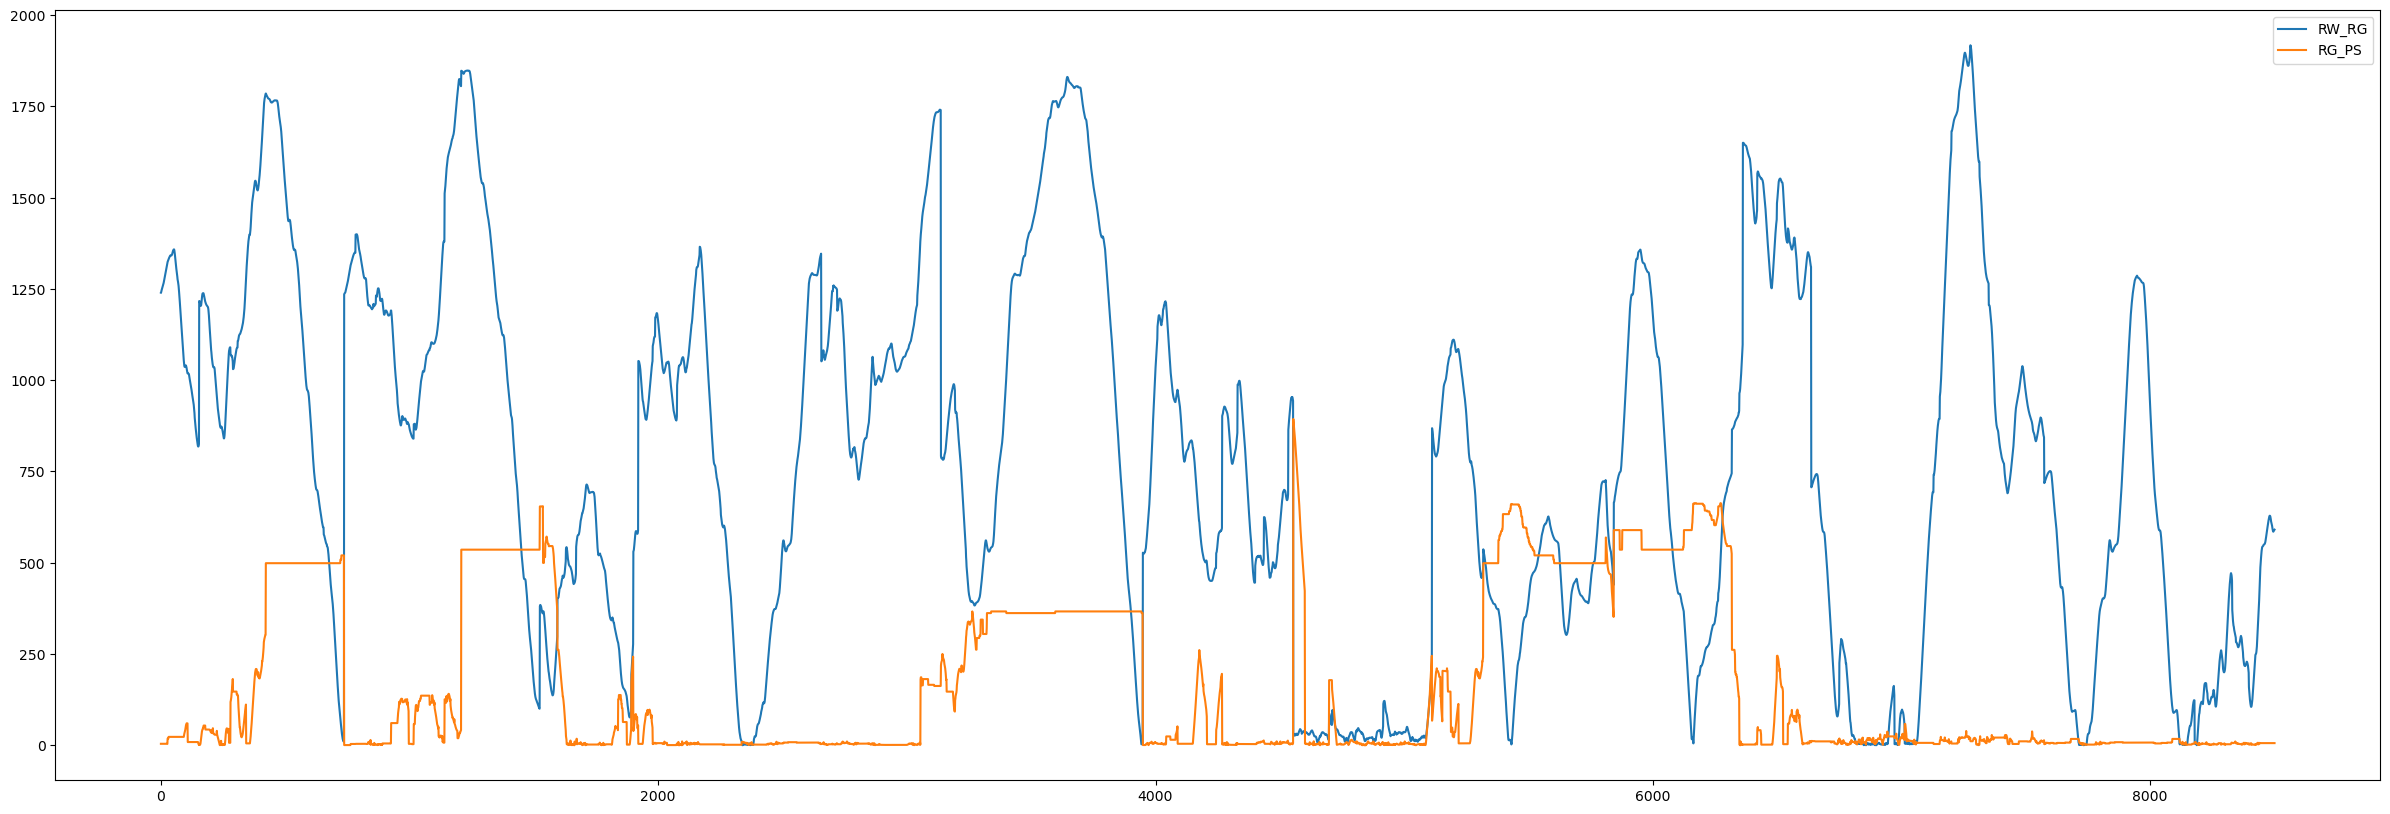

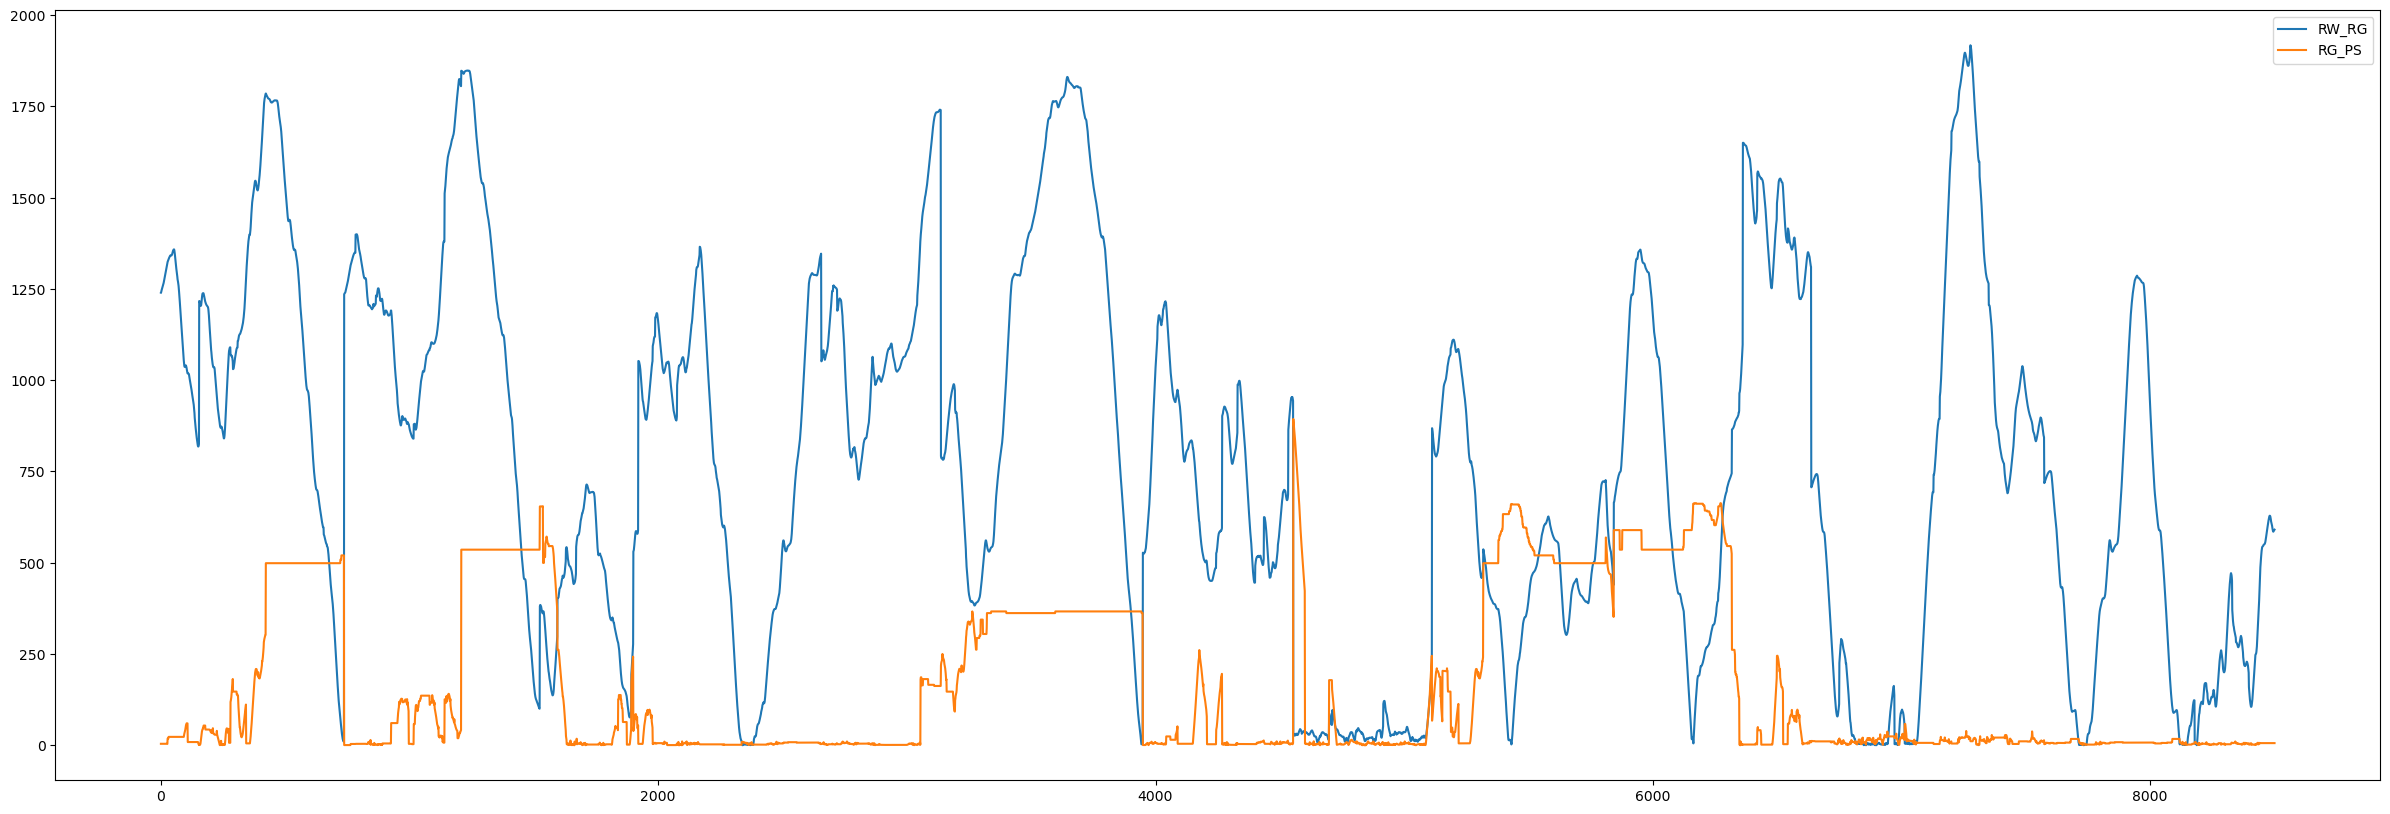

In [5]:
#main('2022_09_14','_12_27',['RG','LA','PS'])
#main('2022_09_14','_12_48',['RG','LA','PS'])
#main('2022_09_15','_08_50',['RW','RG','PS'])
#main('2022_09_15','_09_2',['RW','RG','PS'])
#main('2022_09_15','_09_59',['RW','RG','PS'])
#main('2022_09_15','_11_38',['RW','RG','PS'])

#main('2022_09_13','_09_3',['RW','LA','PS'])
#main('2022_09_14','_08_4',['RG','LA','PS'])
#main('2022_09_14','_12_06',['RG','LA','PS'])
#main('2022_09_13','_08_37',['RW','LA','PS'])


################

main('2022_09_13','_09_0',['RW','LA','PS'])
main('2022_09_13','_10_0',['RW','LA','PS'])
main('2022_09_13','_11_51_12',['RW','LA','PS'])
main('2022_09_13','_12_2',['RW','LA','PS'])
main('2022_09_14','_08_4',['RG','LA','PS'])
main('2022_09_14','_09_10_09',['RG','LA','PS'])
main('2022_09_14','_09_3',['RG','LA','PS'])
main('2022_09_14','_11_45',['RG','LA','PS'])
